# EOF analysis on a space-time climate field

This notebook uses the [following paper by Clara Deser and Maurice Blackmon](https://doi.org/10.1175/1520-0442(1995)008<1677:OTRBTA>2.0.CO;2) as a jumping off point to explore the application of EOF analysis to a space-time climate field, in this case sea surface temperature anomalies:

>Deser, C. and Blackmon, M.L., 1995. On the Relationship between Tropical and North Pacific Sea Surface Temperature Variations. _Journal of Climate_, 8(6), 1677-1680.

We seek to use EOF analysis to identify the leading patterns of co/variance in tropical and North Pacific sea surface temperature (SST) anomalies in a gridded dataset. As we've seen over the last few weeks (and will continue to do so):

>'Given any space-time meteorological field, EOF analysis finds a set of orthogonal spatial patterns along with a set of associated uncorrelated time series or principal components (PCs)' [Hannachi et al. (2007)](https://doi.org/10.1002/joc.1499)

In this notebook, we'll see how to find these new paired space-time patterns in a 3-dimensional field (time, latitude, longitude) of climate data.

We'll first read in the netcdf file, deal with missing data points, modify the coordinate system to make our lives easier, and then slice out the spatial domain we want.  We'll then create a seasonal winter average, reshape our data, calculate the covariance matrix of our field, and find the eigenvectors and eigenvalues using singular value decomposition.  Having done that, we'll calculate the time series expansion for our leading EOF patterns (sometimes called signals, scores, or PCs), and plot our new space-time modes so we can interpret them.  This notebook therefore isn't only about EOF analyses or even specifically about EOF analysis and inference of Pacific SSTs - rather, its shows you one approach to applying the theory and math we've learned in lecture and in simplified form on the Iris datase to a large 3-dimensional dataset. 

We're using the singular value decomposition of the covariance matrix here so that we can see and understand the connection between our earlier exposure to co/variance and linear algebra and EOF analysis.  There are faster ways to do this -- let alone existing packages -- but having a chance to roll your own code and follow the process will give you, I hope, a better understanding of these analyses. 


First let's import our packages.  Remember that we'll need Cartopy (as buggy as it can be) for mapping in Matplotlib.  Xarray will allow us to easily read and manipulated 3 dimensional data stored in netcdf files, and Numpy and Pandas as usual will do a lot of the math for us. 

In [57]:
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

# nicely render figures in the notebook 
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Cartopy gives a lot of warnings when downloading map data, which we'll suppress
import warnings
warnings.filterwarnings("ignore") 

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
plt.rcParams['font.family'] = 'Helvetica'

# import cartopy 
import cartopy # base Cartopy
import cartopy.crs as ccrs # shortcut to the coordinate reference system
import cartopy.feature as cfeature # add map features


### Opening our dataset in `xarray`

We'll first open our sea surface temperature dataset using xarray and then we'll move onto dealing with missing data and changing the coordinate system.  `xarray.open_dataset` quickly and easily opens our netcdf file.  

The data we're using is the Hadley Centre Sea Ice and Sea Surface Temperature data set (HadISST), available here: https://www.metoffice.gov.uk/hadobs/hadisst/.  It contains globally-complete fields of SST and sea ice concentration on a 1 degree latitude-longitude grid from 1870 to the present.  It is too large to host on Github, but you can get it directly from the link above or from the course D2L page.


In [58]:
# open our file into a DataSet and take a look:
ds = xr.open_dataset('HadISST_sst.nc') 
ds


<xarray.Dataset> Size: 477MB
Dimensions:    (time: 1840, nv: 2, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615234 ... 2...
  * latitude   (latitude) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 15kB ...
    sst        (time, latitude, longitude) float32 477MB ...
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    5/6/2023 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

Because we'll only be using the SST data, we can pull out that variable out of the _DataSet_ `ds` and into a _DataArray_ we'll call `sst` to simplify things a bit:

In [59]:
# pull the sst variable out of the DataSet. You can see it is now a DataArray with all the coordinate information brought along
sst = ds.sst
sst

<xarray.DataArray 'sst' (time: 1840, latitude: 180, longitude: 360)> Size: 477MB
[119232000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615234 ... 2...
  * latitude   (latitude) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

### Filling negative numbers

Recall from our earlier lecture that there are missing data in the netCDF that are not handled by the import command above.  Specifically, there are non-NaN numerical indicators of missing SST data in the presense of sea ice.  For some reason the current version of the HadISST netcdf has the wrong missing value stored in the metadata.  But no worries, we can deal with it.  The next line handles this by using the `.where` syntax.  The line in the code block below essentially says 'Hey, xarray, tell me where the SST values in the DataArray are greater than or equal to zero, and where they are not please make those values into NaNs':

In [60]:
# turn negative SST values in NaN
sst = sst.where(sst >= 0, np.nan)

### Dealing with longitude coordinate systems

We've got one more problem to deal with. Well, maybe not a problem, but we can make our lives significantly easier by changing the coordinate system for longitude (which you can see above goes from -179.5 to 179.5) into a 0 to 360 coordinate system.  The following code block shows one way to do this.  In the first line of code, we use xarray's [`.assign_coords` method](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.assign_coords.html) to change the longitude from the existing -180 to 180 system to the 0 to 360.  This is accomplished by way of [the modulo operator, `%`](https://docs.python.org/3.3/reference/expressions.html#binary-arithmetic-operations) (nope, it is not percent sign).  In typical usage, the % (modulo) operator give you the remainder from the division of the first argument by the second.  So, wben the first number is bigger than the second, you get the remainder from division.  But when the second number is bigger than the first, two different behaviors take over: (1) When the first number is smaller than the second and is positive, the modulo just returns the first number (or, in words: 'the second number goes into the first by less than 1, so the remainder is the original number because it is all remainder').  When the first number is smaller than the second and the first is negative, though, [things are different](https://stackoverflow.com/questions/3883004/how-does-the-modulo-operator-work-on-negative-numbers-in-python).   One way people explain it is as ['clock arithmetic'](https://realpython.com/python-modulo-operator/), but the simplest way to think of the conversion between the two longitude systems is that when the numerator is between -180 and 0, the modulo returns a number that is equivalent to making the numerator positive and asking 'how far do I need to get to 360?' - this is the essence of [modular arithmetic](https://betterexplained.com/articles/fun-with-modular-arithmetic/) -- how do we account for the behavior of numbers when their value 'wrap around' at a certain point (like for instance at the dateline or prime meridian!).

Confused?  Yeah.  Try the following and see how the modulo are calculated ane therefore how using modulo is a simple way to map the longitude system that includes negative numbers west of the prime meridian (-180 to 180) to one where longitude climbs smoothly from prime meridian until they circle the globe:

In [65]:
fake_longitudes = np.linspace(-180,180,360,endpoint=True,dtype=int)
for n in fake_longitudes:
    print(n, n % 360) # new coordinate is simply the modulo of the old coordinate and 360

-180 180
-179 181
-178 182
-177 183
-176 184
-175 185
-174 186
-173 187
-172 188
-171 189
-170 190
-169 191
-168 192
-167 193
-166 194
-165 195
-164 196
-163 197
-162 198
-161 199
-160 200
-159 201
-158 202
-157 203
-156 204
-155 205
-154 206
-153 207
-152 208
-151 209
-150 210
-149 211
-148 212
-147 213
-146 214
-145 215
-144 216
-143 217
-142 218
-141 219
-140 220
-139 221
-138 222
-137 223
-136 224
-135 225
-134 226
-133 227
-132 228
-131 229
-130 230
-129 231
-128 232
-127 233
-126 234
-125 235
-124 236
-123 237
-122 238
-121 239
-120 240
-119 241
-118 242
-117 243
-116 244
-115 245
-114 246
-113 247
-112 248
-111 249
-110 250
-109 251
-108 252
-107 253
-106 254
-105 255
-104 256
-103 257
-102 258
-101 259
-100 260
-99 261
-98 262
-97 263
-96 264
-95 265
-94 266
-93 267
-92 268
-91 269
-90 270
-89 271
-88 272
-87 273
-86 274
-85 275
-84 276
-83 277
-82 278
-81 279
-80 280
-79 281
-78 282
-77 283
-76 284
-75 285
-74 286
-73 287
-72 288
-71 289
-70 290
-69 291
-68 292
-67 293
-66 294

Note that the alternative, switching from 0 to 360 to a -180 to 180 coordinate would be:

In [64]:
fake_longitudes = np.linspace(0,360,360,endpoint=True,dtype=int)
for n in fake_longitudes:
    print(n, ((n + 180) % 360 - 180)) # new coordinate is the modulo of sum of the old coordinate and 180 with 360 less 180

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30
31 31
32 32
33 33
34 34
35 35
36 36
37 37
38 38
39 39
40 40
41 41
42 42
43 43
44 44
45 45
46 46
47 47
48 48
49 49
50 50
51 51
52 52
53 53
54 54
55 55
56 56
57 57
58 58
59 59
60 60
61 61
62 62
63 63
64 64
65 65
66 66
67 67
68 68
69 69
70 70
71 71
72 72
73 73
74 74
75 75
76 76
77 77
78 78
79 79
80 80
81 81
82 82
83 83
84 84
85 85
86 86
87 87
88 88
89 89
90 90
91 91
92 92
93 93
94 94
95 95
96 96
97 97
98 98
99 99
100 100
101 101
102 102
103 103
104 104
105 105
106 106
107 107
108 108
109 109
110 110
111 111
112 112
113 113
114 114
115 115
116 116
117 117
118 118
119 119
120 120
121 121
122 122
123 123
124 124
125 125
126 126
127 127
128 128
129 129
130 130
131 131
132 132
133 133
134 134
135 135
136 136
137 137
138 138
139 139
140 140
141 141
142 142
143 143
144 144
145 145
146 146
147 147
148 148
149 149
150 150
151 151
152 

But back to our actual data - the first thing we're going to do is map the -180 to 180 system to the 0 to 360 system and assign that to the coordinates of SSt.  Because these will then be out of order, we're going to sort everything in sst by the longitude values (which now go from 0 to 360).  There is also another example using [xarray's `.roll`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.roll.html) if you like to learn new things but also make things complicated. 

In [67]:
# change the longitudes from -180,180 to 0,360
sst = sst.assign_coords(longitude=(sst.longitude % 360))

# now, sort the coordinates and associated data so they are in the correct order from 0 to 360
sst = sst.sortby(sst.longitude)

# This is an alternative way to do the same thing, but I find it less intuitive compared to the single step above
# sst = sst.roll(longitude=int(len(sst['longitude']) / 2), roll_coords=True)
sst

<xarray.DataArray 'sst' (time: 1840, latitude: 180, longitude: 360)> Size: 477MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]],
      shape=(1840, 180, 360), dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615234 ... 2...
  * latitude   (latitude) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

### Sanity check

'[Sanity check](https://en.wikipedia.org/wiki/Sanity_check)' is a term of art in computer programming, mathematics, and other physical sciences that relates to quickly evaluating something to look for gross or obvious errors.   We'd like to always make sure that after all the things we did to our data, that everything still look aprroximately correct - continents are in the right place relative to oceans, latitude and longitude make sense, the tropics are warm and poles are cold, etc.  If you want to see a cringe-worthy example of **not** doing a sanity check, see here: '[Erroneous model field representations in multiple pseudoproxy studies: Corrections and implications](https://doi.org/10.1175/2010JCLI3742.1)'

Checking in on your data regularly - looking at the size or arrays, the means and standard deviations, maps of simple quantities, the quantity of missing data, relative magnitudes, etc. is always a good idea, and is especially a good idea after you've done any manipulation of the data -- like changing the coordinate system, slicing out a piece, upscaling or downscaling, dealing with missing data, etc. 

For our sanity check here we'll just do a simple plot of the long-term mean of the SST data.  This gives us the quickest of looks at things like - do ocean temperatures make sense (cold in the poles, warm in the tropics), are the continents in the right place, and does longitude and latitude look correct. 

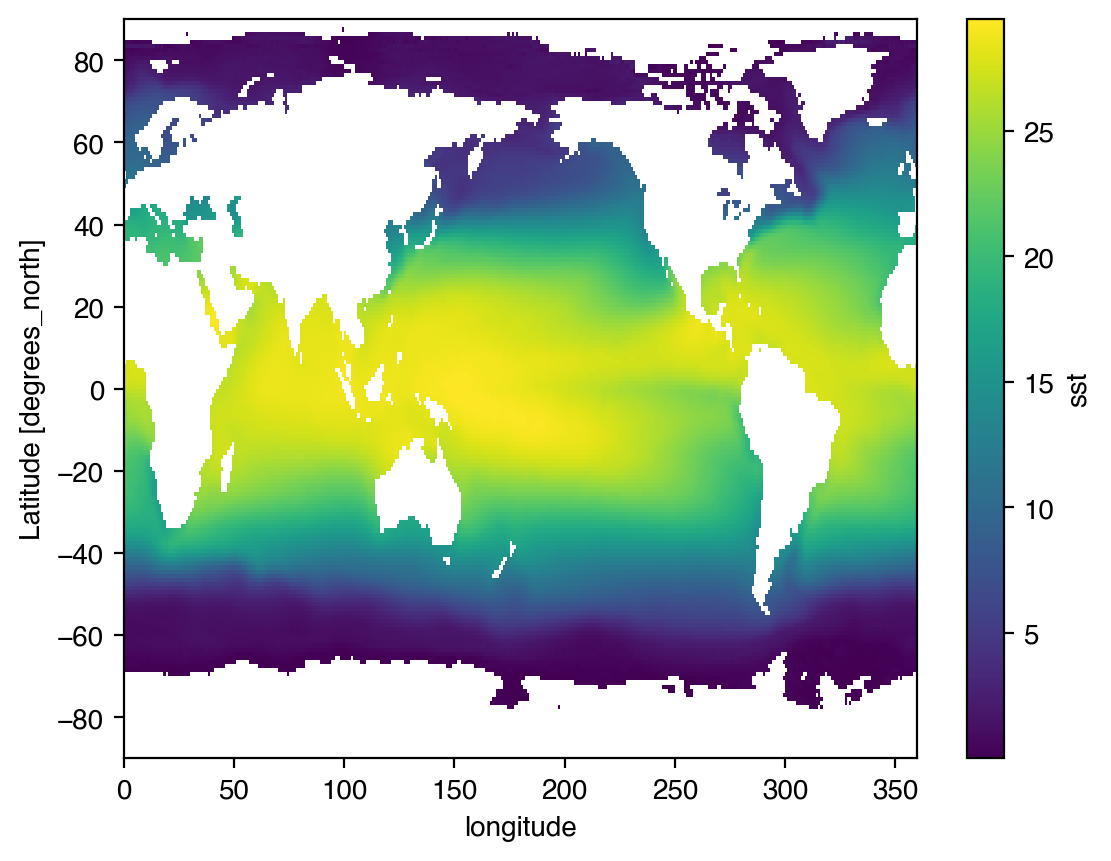

In [68]:
sst.mean(dim="time").plot() # this says 'hey, xarray, take the mean over all the time points and plot the 2d result

Looks good? If so, let's continue

### Subset of our data

We want a subset of our data from the tropical and north Pacific, just a Deser and Blackmon used.  We can do that using xarray's `.sel` and `.slice` and specifying the bounding latitudes and longitudes we want.  Note that we don't need to use a `nearest` specifier because we're using `.slice`, which take the values between the two specified for the coordinates (or, in other words 'which values have coordinates inside of these bounds?').  We'll provide the minimum and maximum latitudes are scalar variables (which allows us to easily alter these later if we wish) and then call the `.sel` and `slice=()` combination to extract.  Note that here I'm overwriting the sst DataArray, but you could also output the slice to a new DataArray if you wish:

In [69]:
# latitude bounds
min_lat = -20.0
max_lat = 60.00

# longitude bounds
min_lon = 120
max_lon = 260

# select a slice and overwrite sst with the output and then take a look
sst = sst.sel(longitude=slice(min_lon,max_lon),latitude=slice(max_lat,min_lat))
sst


<xarray.DataArray 'sst' (time: 1840, latitude: 80, longitude: 140)> Size: 82MB
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [29.362446, 29.487097, 29.582   , ..., 23.577778, 23.453806,
         23.31004 ],
        [29.349419, 29.494856,       nan, ..., 23.556343, 23.443325,
         23.320164],
        [29.328918,       nan,       nan, ..., 23.578579, 23.463644,
         23.336973]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [30.66763 , 30.466814, 30.153542, ..., 24.475985, 24.368017,
         24.316048],
        [30.661644, 30.444641,       nan, ..., 24.50286 , 24.387665,
         24.33868 ],
        [30.688522,       nan,       nan, ..., 24.679466, 24.54036 ,
         24.46276 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [29.549414, 29.437786, 29.236914, ..., 24.836254, 24.720978,
         24.571827],
        [29.519018, 29.374123,       nan, ..., 24.84084 , 24.749306,
         24.610146],
        [29.564308,       nan,       nan, ..., 24.875479, 24.788921,
         24.650368]]], shape=(1840, 80, 140), dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615234 ... 2...
  * latitude   (latitude) float32 320B 59.5 58.5 57.5 56.5 ... -17.5 -18.5 -19.5
  * longitude  (longitude) float32 560B 120.5 121.5 122.5 ... 257.5 258.5 259.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

I'll also pull out the latitude and longitude coordiates from the DataArray for simplicity later:

In [70]:
# extract coordinates from the DataArray
lat = sst.latitude
lon = sst.longitude

Let's do one more sanity check now on our DataArray.  If we've done what we think we did, the `.plot` should show mean SSTs in the tropical and north Pacific, with the warmest SSTs in the tropics, colder conditions at the poles, and the continents where they belong.  Again, this might seem a silly thing to worry about, but any time you do a manipulation of your data, you should check to make sure what happened is what you meant to happen!

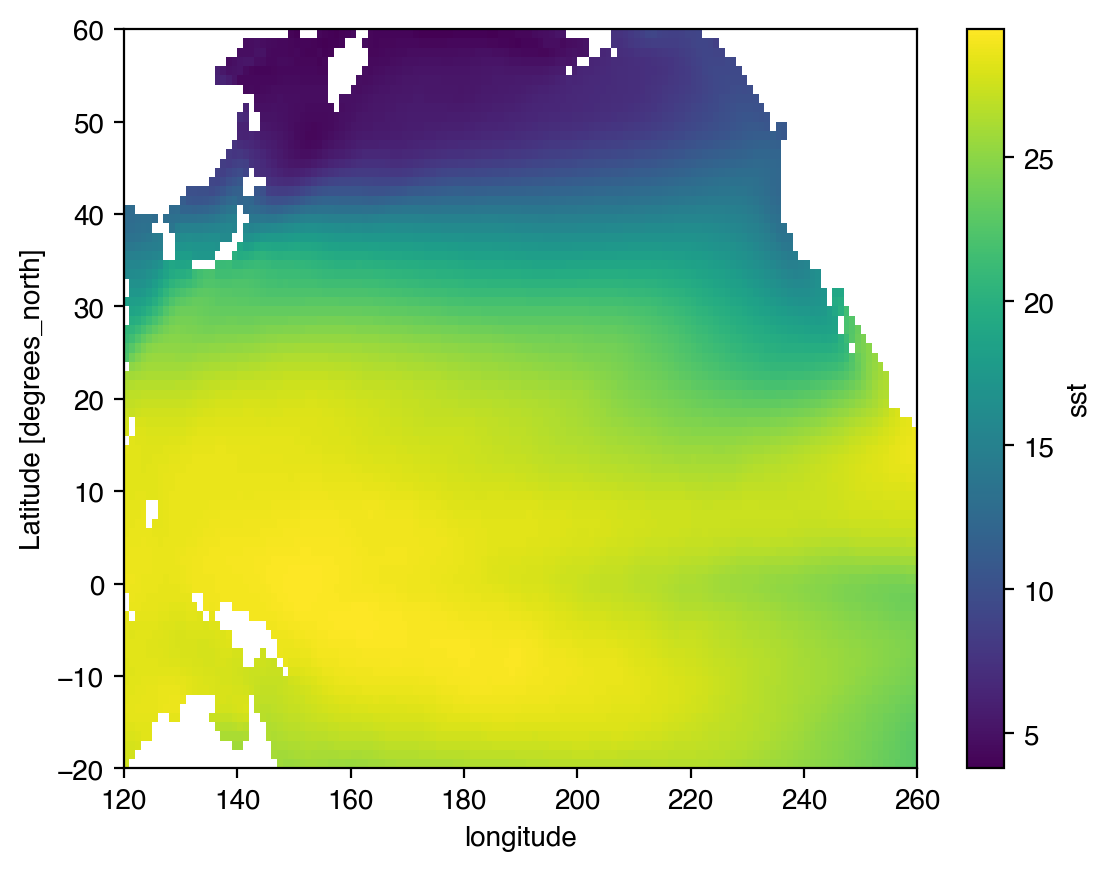

In [71]:
sst.mean(dim="time").plot()

Look good? It does to me - cold is where cold should be, warm is where warm should be, I can identify the land masses and the geography looks right. So, let's more on. 

### Anomallies and seasonal means

For our analysis we're going to want the November through March mean value for each year.  At this stage we could also create monthly anomalies by calculating the average monthly SST at each grid point (called the 'climatology' or the long-term monthly average) using the combination of `.groupby()` and `.mean()`.  For this analysis it isn't really necessary, since we'll remove the long-term seasonal mean later anyway, but if you were interested in doing this (it does no harm to do this now) here's one way:

In [72]:
# calculate the monthly mean at each point - climatology
sst_clm = sst.groupby('time.month').mean(dim='time')

# calculate the anomaly anomaly - use groupby to tell xarray that sst_clm should be applied to each group of months, since sst_clm has only 12 time coordinate points
sst_anom = sst.groupby('time.month') - sst_clm

OK, but here is what we are really after - we want to calculate the November through March average SST value for each location in our domain.  Previously in class I showed two possible ways to do this.  The way where we use `.rolling()` to calculate a rolling mean and they select out the rolling 5-month mean value associated with March.  Of the two ways, I slightly prefer this one because the datetime associated with this season is attached to the March (not the November), which is closer to how we typically treat cross-year seasons in climate science.  I wish xarray gave us the easier way to do seasons outside of the four it specifies. But here we go:

In [85]:
# Calculate the 5-month rolling mean, skipping NaN values
sst_ = sst_anom.rolling(time=5).mean()

# Select out month 3 (March) to get the average over NDJFM
winter = sst_[sst_.time.month == 3]

# take a look
winter


<xarray.DataArray 'sst' (time: 154, latitude: 80, longitude: 140)> Size: 7MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.49474144,  0.3274166 ,  0.19043502, ..., -0.99293786,
         -0.9375919 , -0.8937248 ],
        [ 0.53049964,  0.3721817 ,         nan, ..., -0.9848999 ,
         -0.9492477 , -0.91407394],
        [ 0.5399631 ,         nan,         nan, ..., -0.85416603,
         -0.911668  , -0.91519433]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.22848244,  0.15104675,  0.04661179, ..., -0.32308045,
         -0.28503913, -0.22076264],
        [ 0.19522324,  0.15162773,         nan, ..., -0.28414115,
         -0.27277222, -0.21742745],
        [ 0.17415123,         nan,         nan, ..., -0.1474926 ,
         -0.2172207 , -0.21474114]]], shape=(154, 80, 140), dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1kB 1870-03-16T11:59:59.340820312 ... 20...
  * latitude   (latitude) float32 320B 59.5 58.5 57.5 56.5 ... -17.5 -18.5 -19.5
  * longitude  (longitude) float32 560B 120.5 121.5 122.5 ... 257.5 258.5 259.5
    month      (time) int64 1kB 3 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3 3

### Removing a spurious year from our DataArray

Now, remember what we talked about in lecture.  Xarray in trying to be helpful and calculated a 5-month average from November to March that includes November 1869 and December 1869, which don't actually exist in our dataset.  This means that our first value in our new seasonal data is not valid, and indeed fortunately it is full of NaN values - we can see this with a simple plot (sanity check!):

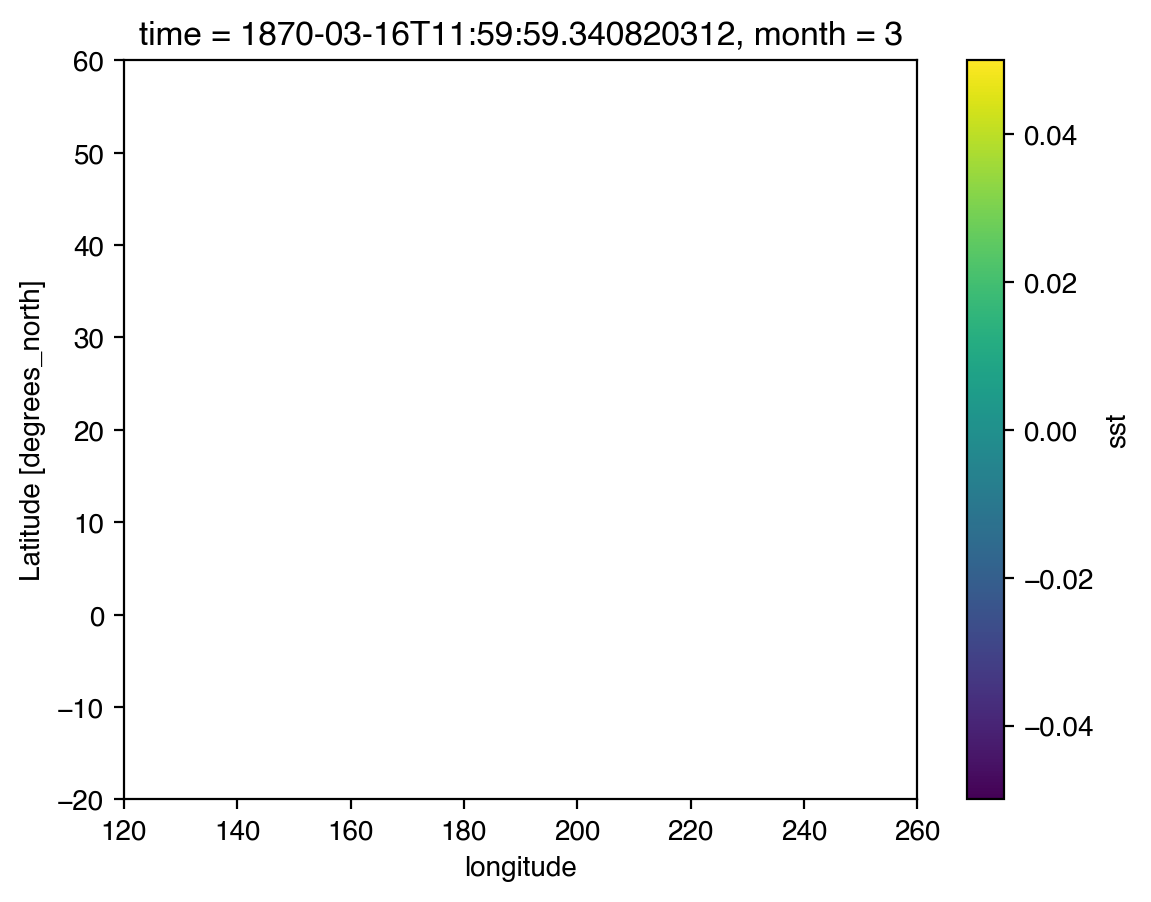

In [86]:
winter.isel(time=0).plot() # map is empty, compare to winter.isel(time=1).plot() in the next code block!

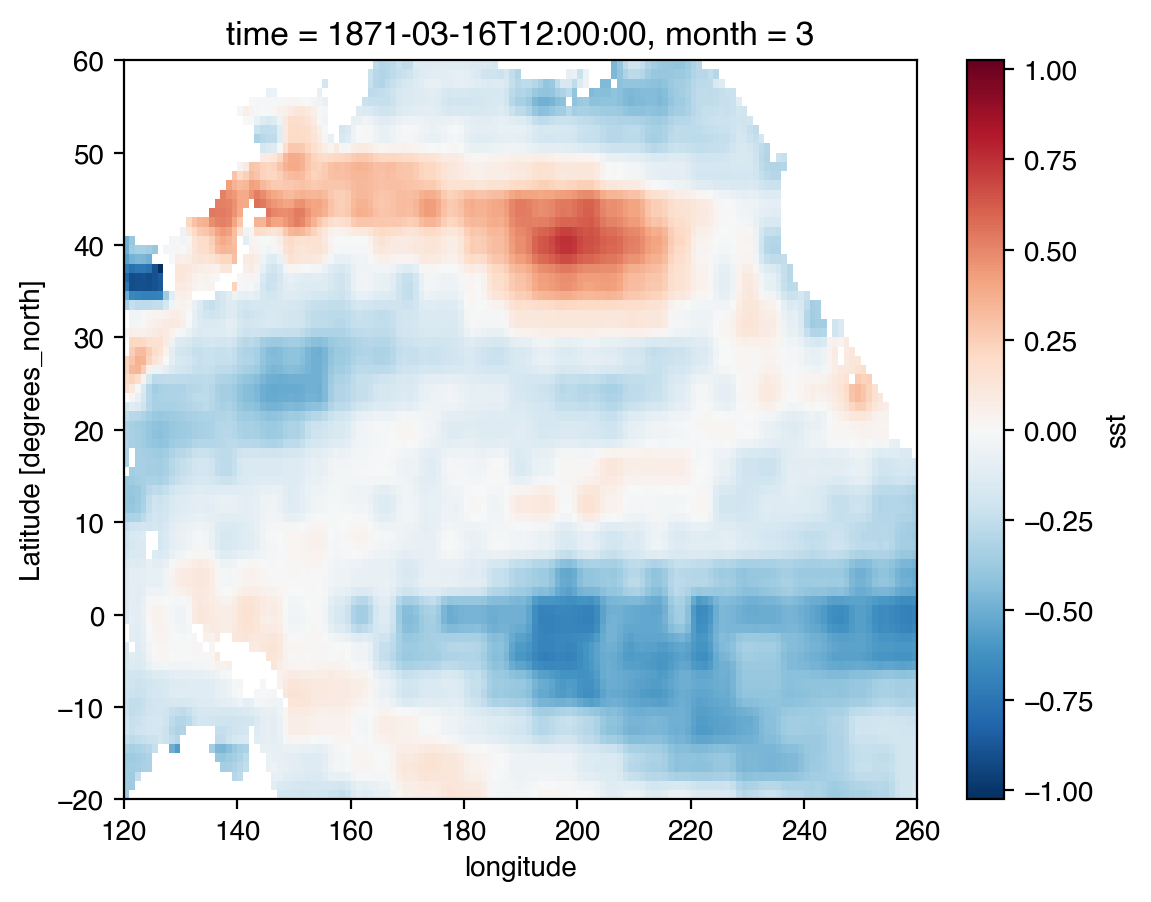

In [87]:
# but this data point is OK - November 1871 through March 1872
winter.isel(time=1).plot()

No problem, we can use xarray's `.drop_isel` to remove the first time dimension in the dataset.  

In [90]:
# see if all the values in timestep 0 are null - they are (returns True)!
winter.isel(time=0).isnull().all()

# look at winter again - note the 154 years of winter averages and the first date in March 1870
winter


<xarray.DataArray 'sst' (time: 154, latitude: 80, longitude: 140)> Size: 7MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.49474144,  0.3274166 ,  0.19043502, ..., -0.99293786,
         -0.9375919 , -0.8937248 ],
        [ 0.53049964,  0.3721817 ,         nan, ..., -0.9848999 ,
         -0.9492477 , -0.91407394],
        [ 0.5399631 ,         nan,         nan, ..., -0.85416603,
         -0.911668  , -0.91519433]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.22848244,  0.15104675,  0.04661179, ..., -0.32308045,
         -0.28503913, -0.22076264],
        [ 0.19522324,  0.15162773,         nan, ..., -0.28414115,
         -0.27277222, -0.21742745],
        [ 0.17415123,         nan,         nan, ..., -0.1474926 ,
         -0.2172207 , -0.21474114]]], shape=(154, 80, 140), dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1kB 1870-03-16T11:59:59.340820312 ... 20...
  * latitude   (latitude) float32 320B 59.5 58.5 57.5 56.5 ... -17.5 -18.5 -19.5
  * longitude  (longitude) float32 560B 120.5 121.5 122.5 ... 257.5 258.5 259.5
    month      (time) int64 1kB 3 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3 3

In the code block below, we do the actual dropping of that first year:

In [91]:
# use drop_isel to drop the first year and reassign to winter
winter = winter.drop_isel(time=0)

# look at winter again - note the 153 years of winter averages and the first date in March 1871
winter


<xarray.DataArray 'sst' (time: 153, latitude: 80, longitude: 140)> Size: 7MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.3574379 , -0.36130792, -0.24615288, ..., -0.19456215,
         -0.19840813, -0.18758011],
        [-0.3616642 , -0.37122956,         nan, ..., -0.19337884,
         -0.19689941, -0.17587814],
        [-0.36312598,         nan,         nan, ..., -0.19694138,
         -0.19482231, -0.16612549]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.49474144,  0.3274166 ,  0.19043502, ..., -0.99293786,
         -0.9375919 , -0.8937248 ],
        [ 0.53049964,  0.3721817 ,         nan, ..., -0.9848999 ,
         -0.9492477 , -0.91407394],
        [ 0.5399631 ,         nan,         nan, ..., -0.85416603,
         -0.911668  , -0.91519433]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.22848244,  0.15104675,  0.04661179, ..., -0.32308045,
         -0.28503913, -0.22076264],
        [ 0.19522324,  0.15162773,         nan, ..., -0.28414115,
         -0.27277222, -0.21742745],
        [ 0.17415123,         nan,         nan, ..., -0.1474926 ,
         -0.2172207 , -0.21474114]]], shape=(153, 80, 140), dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1kB 1871-03-16T12:00:00 ... 2023-03-16T1...
  * latitude   (latitude) float32 320B 59.5 58.5 57.5 56.5 ... -17.5 -18.5 -19.5
  * longitude  (longitude) float32 560B 120.5 121.5 122.5 ... 257.5 258.5 259.5
    month      (time) int64 1kB 3 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3 3

### Reshaping data

Currently in this class, we expect our covariance and SVD analysis to use a 2-dimensional matrix, but we have 3-dimensions in our dataset at the moment - time, latitude, and longitude.  What we'd like is to have all the observations (time) in rows and then all the variables in space in the columns.  To unwrap our 3d DataArray into a 2d matrix, we'll first `.reshape` the data using the following sequence.  First, I'll pull out just the `values` from the DataArray `winter`.  Then, I'll get the `.shape` of that array.  I'm doing this because a little later I'm going to want to put things _back_ in a 3-dimensional form for plotting them on a map, and keeping track of the size of the data before I manipulate it is a good idea.  I'm then going to use Numpy's `reshape` - I tell it I want only 2 dimensions, one the size of the time dimension, and one that is the combined size of the latitude and longitude dimension.  I also specify the `order=F` because (as you saw in the introductory notebooks) this does the reshaping in the way we intend - keeping the first dimension as time and then distributing each latitude and longitude location into columns. 

In [94]:
# get the values from the winter DataArray - at this point they are still 3-dimensional
sst2d = winter.values

# record their original dimensions before we reshape
ntime, nrow, ncol = sst2d.shape

# now reshape, we want rows of the time variable and columns of location - we use 'order=F' because this gives us the correct reshaping
sst2d = np.reshape(sst2d, (ntime, nrow*ncol), order='F')
sst2d

array([[        nan,         nan,         nan, ..., -0.18758011,
        -0.17587814, -0.16612549],
       [        nan,         nan,         nan, ..., -0.5987297 ,
        -0.5386284 , -0.50467646],
       [        nan,         nan,         nan, ..., -0.584679  ,
        -0.54697835, -0.5242268 ],
       ...,
       [        nan,         nan,         nan, ..., -0.78789294,
        -0.7924446 , -0.79200935],
       [        nan,         nan,         nan, ..., -0.8937248 ,
        -0.91407394, -0.91519433],
       [        nan,         nan,         nan, ..., -0.22076264,
        -0.21742745, -0.21474114]], shape=(153, 11200), dtype=float32)

Ok, so now we've got a 2 dimensional matrix of our data - time in rows, locations in columns.  Some of those columns, though, are filled with NaN values (e.g. locations that are land and hence don't have any SST values).  NaNs will in many cases mess up our covariance matrix and will certainly (if they make it that far) mess up our singular value decomposition.  So let's identify the columns where there are no missing values, and only analyze those.  Now, we don't want to entirely get rid of the NaN columns, because when we go to rewrap our data into 3 dimensions again, we're gonna want to know where the land and sea ice were, so we can plot things properly. In the code block below, then, I do a few things.  First, I use one possible way to identify columns that do not have `any` NaN values in them (this being Python, there are other ways you could do this).  I then create a new matrix, `sst2dcomplete` which has only the columns from `sst2d` that are not missing any values.  

In [95]:

# here we say 'tell me where there is NOT even a single NaN in the column.  Returns an array with the size of the columns of sst2d
noMissing = ~np.isnan(sst2d).any(axis=0)
print(noMissing)

# create a new array with only the columns of sst2d that are not missing any data 
sst2dcomplete = sst2d[:, noMissing]

# check - are there any NaN values?  count_nonzero function (recursively) counts how many elements have nonzero or a Boolean method evaluated to True.
print(np.count_nonzero(np.isnan(sst2dcomplete))) # should be zero, indicating the np.isnan contains no True booleans

[False False False ...  True  True  True]
0


Finally, having done that, I remove the mean from each column of my complete matrix.  Then we're ready to calculate the covariance matrix.

(array([1.000e+00, 1.400e+01, 2.320e+02, 2.371e+03, 5.554e+03, 1.123e+03,
        1.200e+01, 1.900e+01, 2.000e+00, 1.000e+00]),
 array([-7.47979882e-08, -5.73451260e-08, -3.98922602e-08, -2.24393943e-08,
        -4.98653208e-09,  1.24663302e-08,  2.99191996e-08,  4.73720618e-08,
         6.48249241e-08,  8.22777864e-08,  9.97306486e-08]),
 <BarContainer object of 10 artists>)

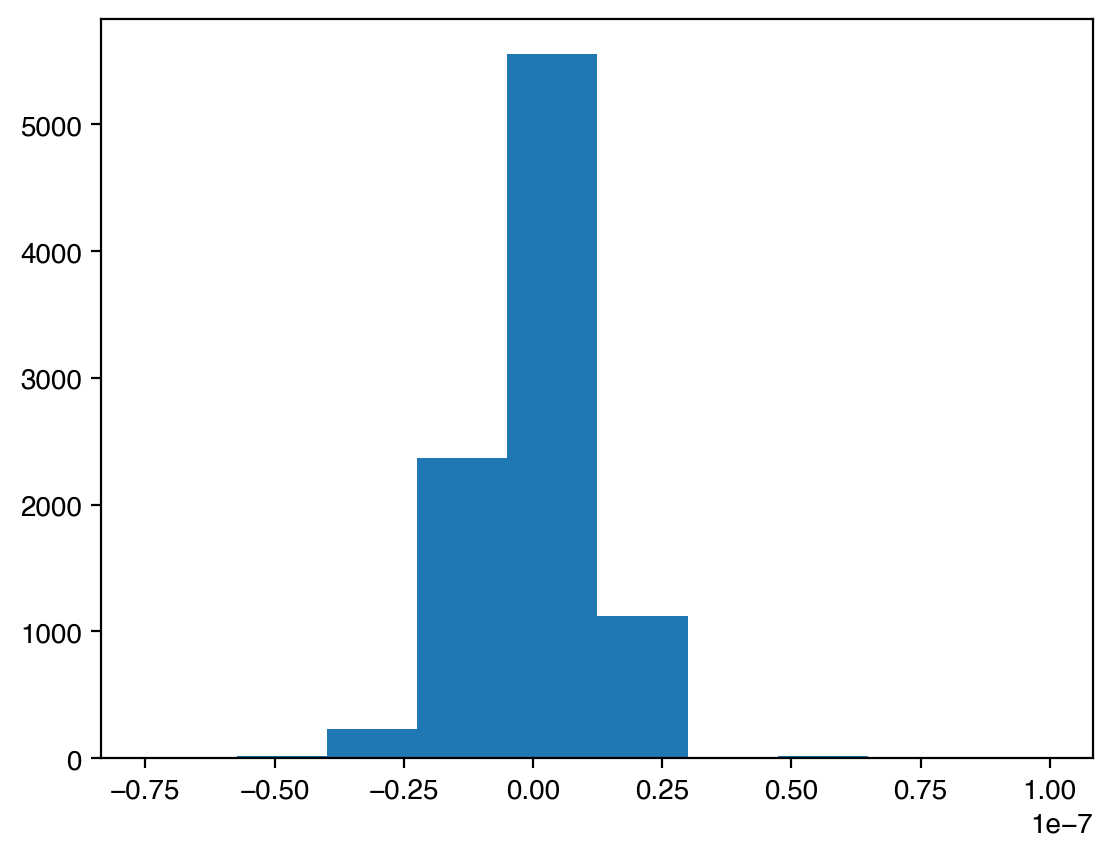

In [96]:
# calculate the anomalies from the long-term seasonal mean for each column
sst_anomalies = sst2dcomplete - sst2dcomplete.mean(axis=0)
plt.hist(np.mean(sst_anomalies,axis=0)) # sanity check! 

### Calculating a covariance matrix

As we saw in an earlier notebook, there are several ways to calculate the covariance matrix - both should work for our purposes, and you can test to see that the give the same result:

In [97]:
# There are two ways to calculate the covariance matrix - both should work
Cn = np.cov(sst2dcomplete,rowvar=False,ddof=1)
Cs = pd.DataFrame(sst2dcomplete).cov(ddof=1)
(Cn==Cs).all().all() # should return True!


np.True_

We've now got a covariance matrix, which contains all the information about the similarities betweeo all our winter SST data locations through time, as well as their respective variances.  We're now ready to factor our covariance matrix into its eigenvectors and eigenvalues, using the Singular Value Decomposition:

### The Singular Value Decomposition

We now move forward and do our Singular Value Decomposition.  Because out matrix is quite large (9329 columns) we can use `sp.sparse.linalg.svds` to calculate the 'economy size' SVD for a small number of modes.  We'll specify `k=2` to tell `sp.sparse.linalg.svds` that we only need the first two eigenvalues and eigenvectors:

In [98]:
# choose one of our covariance matrices
C = Cn

# Run the SVD!
# U, S, V = np.linalg.svd(sst2dcomplete,full_matrices=False) # running this on the covariance matrix would take forever
U, S, V = sp.sparse.linalg.svds(C,k=2) # economy sized, only get the first two eigenvalues/eigenvectors

Scipy does not, however, guarantee that the eigenvalues and eigenvectors are sorted from highest varianace (eigenvalue) to lowest.  So we'll have to check and sort outselves.  This is what the next code block does.  It uses `np.argsort` to get an index for sorting the eigenvalues from largest to smallest, then applies that sorting index to both S and U (the eigenvectors):

In [99]:
# One downside of SciPy is that it does not guarantee the eigenmodes are in order from most to least variance, so we have to do it
sort_index = np.argsort(S)[::-1] # sort in descending order from high to low
S = S[sort_index] # apply the index
U = U[:,sort_index] # apply the index

From  `sp.sparse.linalg.svds`, we get the eigenvectors of the covariance matrix in columns of `U`.  The leading eigenvector will now (after sorting) be in the 0th column, and the 2nd eigenvector in column 1 (zero indexing makes talking about this more difficult, doesn't it?).  Each column of U is a long strung-out vector of 9329 numbers, one each per eigenvector for each location in our Pacific data field that has no missing data.  For plotting the eigenvector values (or loadings, as they are often called), we're going to want to once again reshape the eigenvectors so that they have a latitude and longitude dimension.  Our new array will have dimensions of EOF mode by latitude by longitude.  The following code block shows how we can do that.

First, we'll create an empty matrix that has a row size equal to the total number of latitude and longitude points in our original dataset, _before_ we removed the locations with NaN values.  This is why we saved the size of that matrix in `nrow` and `ncol`.  The first line of code creates this empty matrix with two columns, one for each of our eigenvectors.  In the second line of code, we say 'OK, let's put those eigenvector values in right place - the locations where there were full data columns' - this is where the `noMissing` index comes in useful, in that it allows us to re-insert values for the locations with data in the right place in the new matrix, so that when we rewrap these into 3 dimensions, everything corresponds to the right latitude and longitude.  The last line in the code block below does the actual `.reshape`, telling Python that we want to take that 2 dimensional matrix with the EOFs and put it into a 3 dimensional matrix with latitude and longitude dimensions, and a 3rd length dimension of EOF number (or mode).

In [100]:
## that the eigenvectors in U and put them into an array for plotting
# create an empty matrix full of NaNs with the same number of columns as the original 2-dimensional data and 2 columns
eof = np.full((nrow*ncol, 2), np.nan) # creates the new array full of NaNs 
eof[noMissing,:] = U # take the eigenvectors and put them back in the right place in the eof array 
eof = eof.reshape([nrow,ncol,2], order='F') # finally, reshape back to the original dimensions of latitude and longitude plus the eof dimension for plotting

So, we've got some EOF loadings ready to plot on a map.  But before we do that, we want to get the time series expansion for each eigenmode - we'll do that below.

### Calculating the 'PCs' - the time component

Not only do we get eigenvectors (EOFs, loadings, spatial patterns) and eigenvalues (representing variance in each eigenmode) from the SVD, but we also can get our original time series values _reprojected_ on these new modes.  To do this, we project (==multiply) our original centered (e.g. with zero-mean) data matix onto the eigenvectors.  This process transforms the original data into the new space of the eigenvalues.  Since we started with data that was 'SST anomalies through time', this new projection to create what we call scores or signals or PCs, gives us new time series corresponding to each eigenvalue-eigenvector pair.  This is the temporal representation of the corresponding eigenmode, where the spatial pattern is represented by the eigenvectors. 

Let's first put our linear algebra hats on and consider the size of both our data matrix and economy-sized EOF matrix (**U**).  SciPy's `.sparse.linalg.svds` gives us a row dimension that is the same as the number of columns in our original data (so the 'space' or 'location' dimension) and then 2 columns for each of the 2 eigenvectors.  Our original data has rows corresponding to the number of years in the dataset (n=153) and columns of each gridpoint that has valid SST data (the space dimension).  So, the dimension that _both_ the EOF matrix (**U**) and the original data matrix share is therefore the _spatial_ dimension.  In this current example, that's the rows of the **U** matrix and columns of the data matrix.  If those are our inner dimensions, you can see that the result of matrix multiplying these two matrices will be a matrix with dimenions of time (years) in rows and eigenmodes (2) in columns.  This means that this multiplication of the eigenvectors back onto the original data returns one time series with the same time dimension as the original data per eigenvalue/eigenvector pair!  


In [101]:
print(U.shape) # 9329 rows of value, one per spatial location in our data, and 2 columns, one for each eigenvector
print(sst_anomalies.shape) # 153 years of data in rows, and 9329 spatial locations in columns

# project the eigenvectors on the sst_anomalies to get the time series associated with each of the 2 modes:
pcs = sst_anomalies @ U
pcs.shape # check the shape - we have 153 years in each of 2 modes

(9329, 2)
(153, 9329)


(153, 2)

We've got spatial loadings now as well as the corresponding time series (PCs, or scores). Let's make some plots!

### Plotting EOF patterns

Above we reshaped the eigenvectors into latitude and longitude, so we could plot the values in each eigenvector associated with each SST location.  We call these 'loadings' and you might think about them as the 'weights' of each location on that eigenmode.  Let's make a plot of our spatial loadings - our EOFs - and see the spatial patterns that emerge:

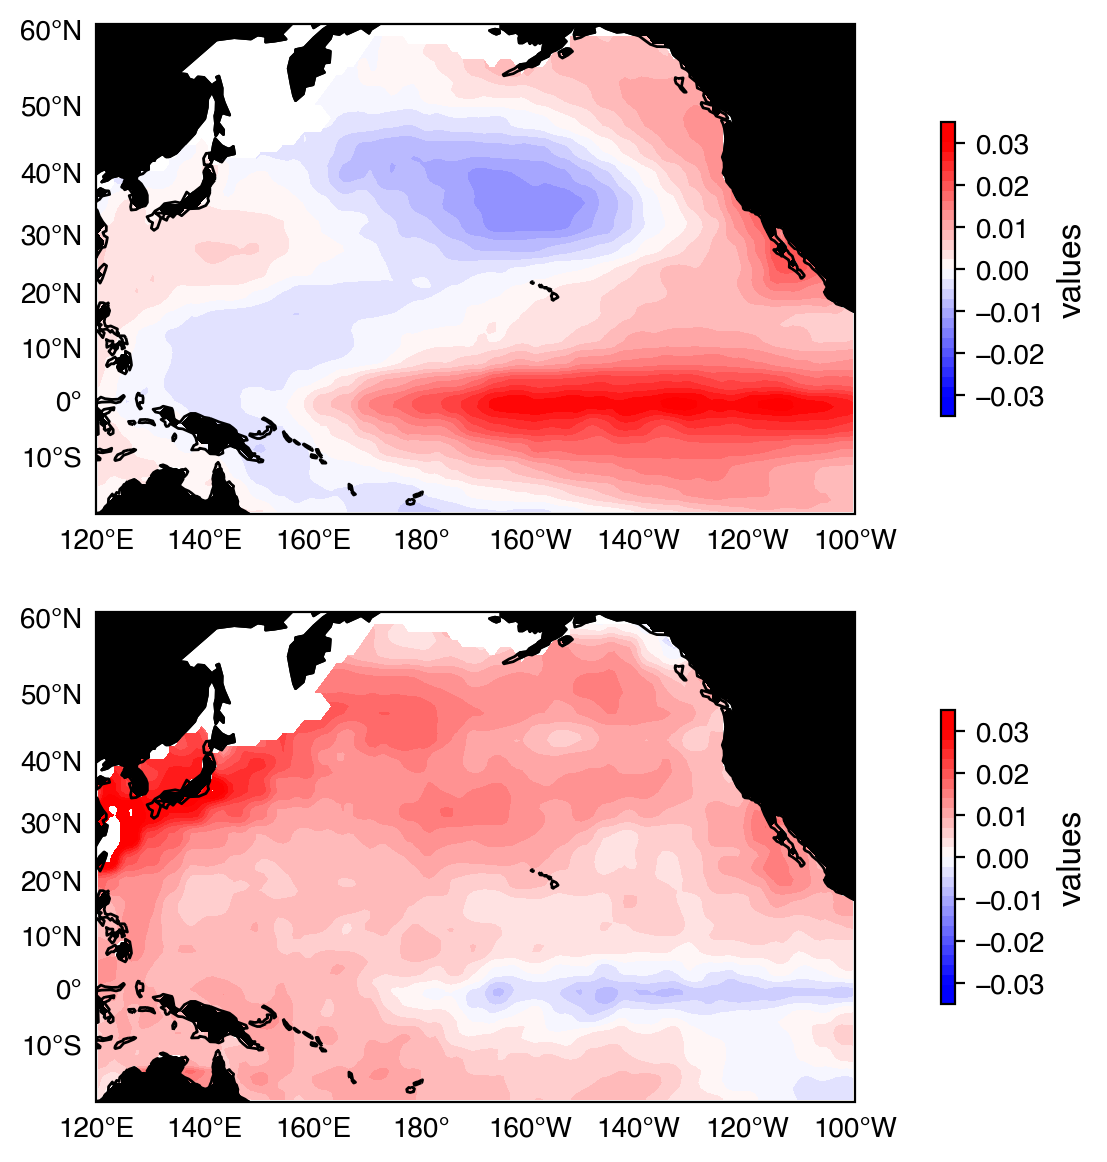

In [104]:
# because .subplots creates the axes, we can tell it about the Cartopy projection here!
fig, axs = plt.subplots(num=1, figsize=(11,7), clear=True,nrows=2,ncols=1,subplot_kw={'projection': ccrs.Miller(central_longitude=260)})

## plot the first axis with a map of the leading (0th) EOF loadings
# plot the coastlines as before
axs[0].coastlines(color="black")  # we can pass arguments to .coastlines function
axs[0].add_feature(cfeature.LAND, color='black') # this uses Cartopy and Natural Earth features to fill the continents black

# specifying the levels of the contour plot we're going to plot gives us more control on the map and colorbar
levels = np.linspace(-0.035, 0.035, 31)

# plot filled contours, specify the levels of the contour intervals, the minimum and maximum values, and specify ccrs.PlateCarree() and use the bwr (blue-white-red) colormap
px1 = axs[0].contourf(lon, lat, eof[:,:,0], levels=levels,vmin=-0.03, vmax=0.03, cmap="bwr",transform=ccrs.PlateCarree())

# Here is where we set the longitude and latitude extent the order is: (longitude1, longitude2, latitude1, latitude2)
axs[0].set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())

# we can make the axes look like we want - here we remove the gridlines, put tell matplotlib where to put axes tickmarks
gl1 = axs[0].gridlines(color='None', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=[-10, 0, 10, 20, 30, 40, 50, 60], xlocs=[120, 140, 160, 180, -160, -140, -120, -100])
 
# we would like a colorbar to allow us to interpret the contour plot - we tell the colorbar which contour plot it is describing by the handle, here 'px1' from above 
cb1 = plt.colorbar(px1, orientation='vertical',shrink=0.6,ticks=[-0.03, -0.02, -0.01, 0, 0.01, 0.02, 0.03])
cb1.set_label('values', fontsize=12) # at this point, the EOFs don't really have a unit, so we put values or we could put 'loadings' 
 
## plot the second axis, now with the second EOF mode (1st-ith)
 
# plot the coastlines as before
axs[1].coastlines(color="black")  # we can pass arguments to .coastlines function
axs[1].add_feature(cfeature.LAND, color='black')

# specifying the levels gives us more control on the map
levels = np.linspace(-0.035, 0.035, 31)

# plot contour and specify ccrs.PlateCarree() and use bwr (blue-white-red) colormap
px2 = axs[1].contourf(lon, lat, -eof[:,:,1], levels=levels,vmin=-0.03, vmax=0.03, cmap="bwr",transform=ccrs.PlateCarree())

# Here is where we set the longitude and latitude extent
axs[1].set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())

gl1 = axs[1].gridlines(color='None', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=[-10, 0, 10, 20, 30, 40, 50, 60], xlocs=[120, 140, 160, 180, -160, -140, -120, -100])
 
# we would like a colorbar to allow us to interpret the contour plot - we tell the colorbar which contour plot it is describing by the handle, here 'px2' from above 
cb2 = plt.colorbar(px2, orientation='vertical',shrink=0.6,ticks=[-0.03, -0.02, -0.01, 0, 0.01, 0.02, 0.03])
cb2.set_label('values', fontsize=12) # at this point, the EOFs don't really have a unit, so we put values or we could put 'loadings' 

Amazing, right?  I've asked you to interpret these patterns for Homework #2, so we'll leave physical interpretation for that exercise. 

### Plotting time series or signals or scores or PCs

Remember that we calculated the time series associated with each of the above spatial loading patterns.  We did so by projecting the eigenvectors on the SST anomaly data, so once again we could think of the eigenvector loadings as the weights that tell us how important each point in space is at determining the new time series:

Text(0, 0.5, 'SCORES')

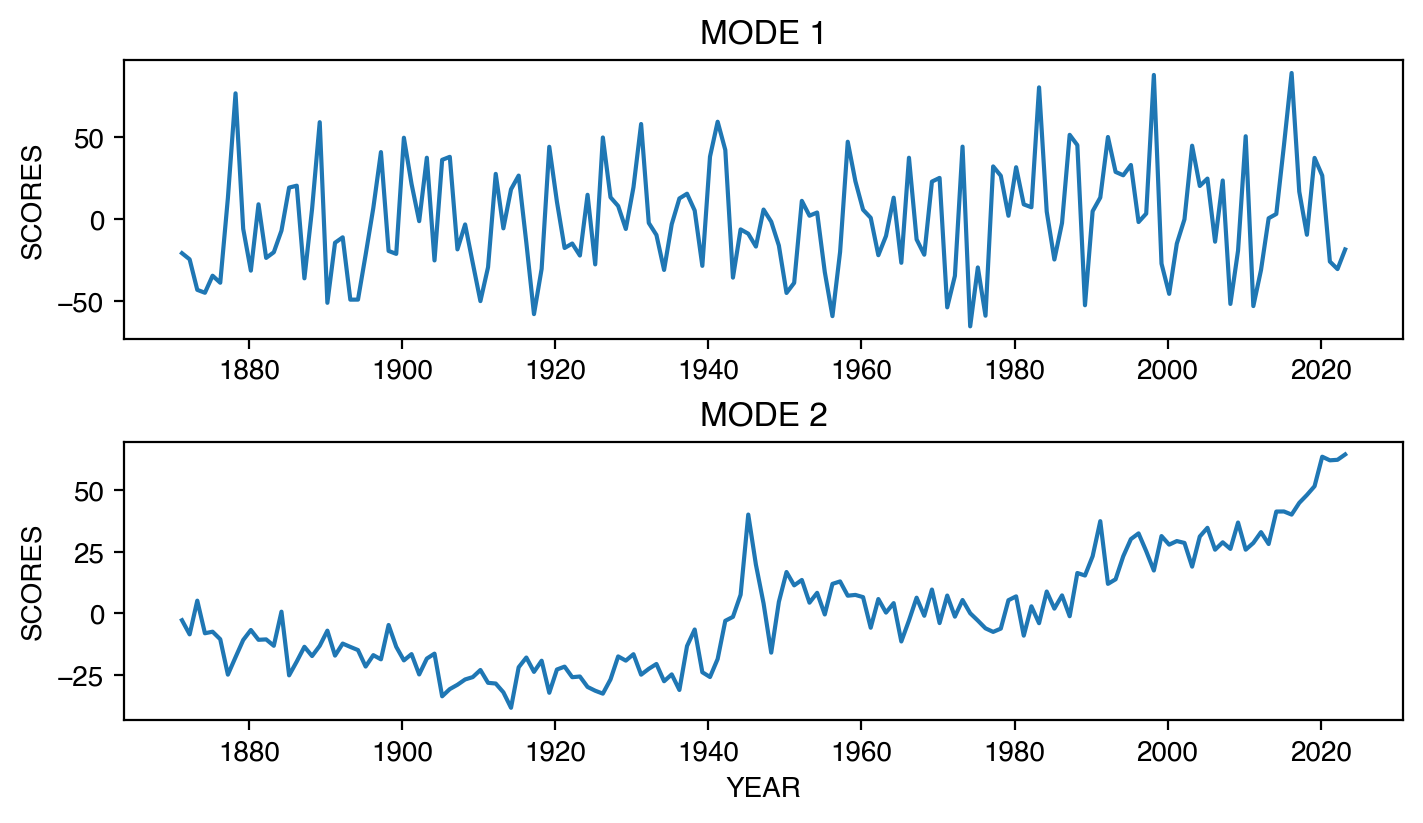

In [105]:
# two time series plots
fig, axs = plt.subplots(num=2, figsize=(7,4), clear=True,nrows=2,ncols=1,layout="constrained")

axs[0].plot(winter.time,pcs[:,0])
axs[0].set_title('MODE 1')
axs[0].set_ylabel('SCORES')

axs[1].plot(winter.time,-pcs[:,1])
axs[1].set_title('MODE 2')
axs[1].set_xlabel('YEAR')
axs[1].set_ylabel('SCORES')

Let's put both the spatial and temporal components together into a single figure.  Here we'll use Matplotlib's [`gridspec`](https://matplotlib.org/stable/api/_as_gen/matplotlib.gridspec.GridSpec.html) to [layout and manipulate the grid](https://matplotlib.org/stable/users/explain/axes/arranging_axes.html).

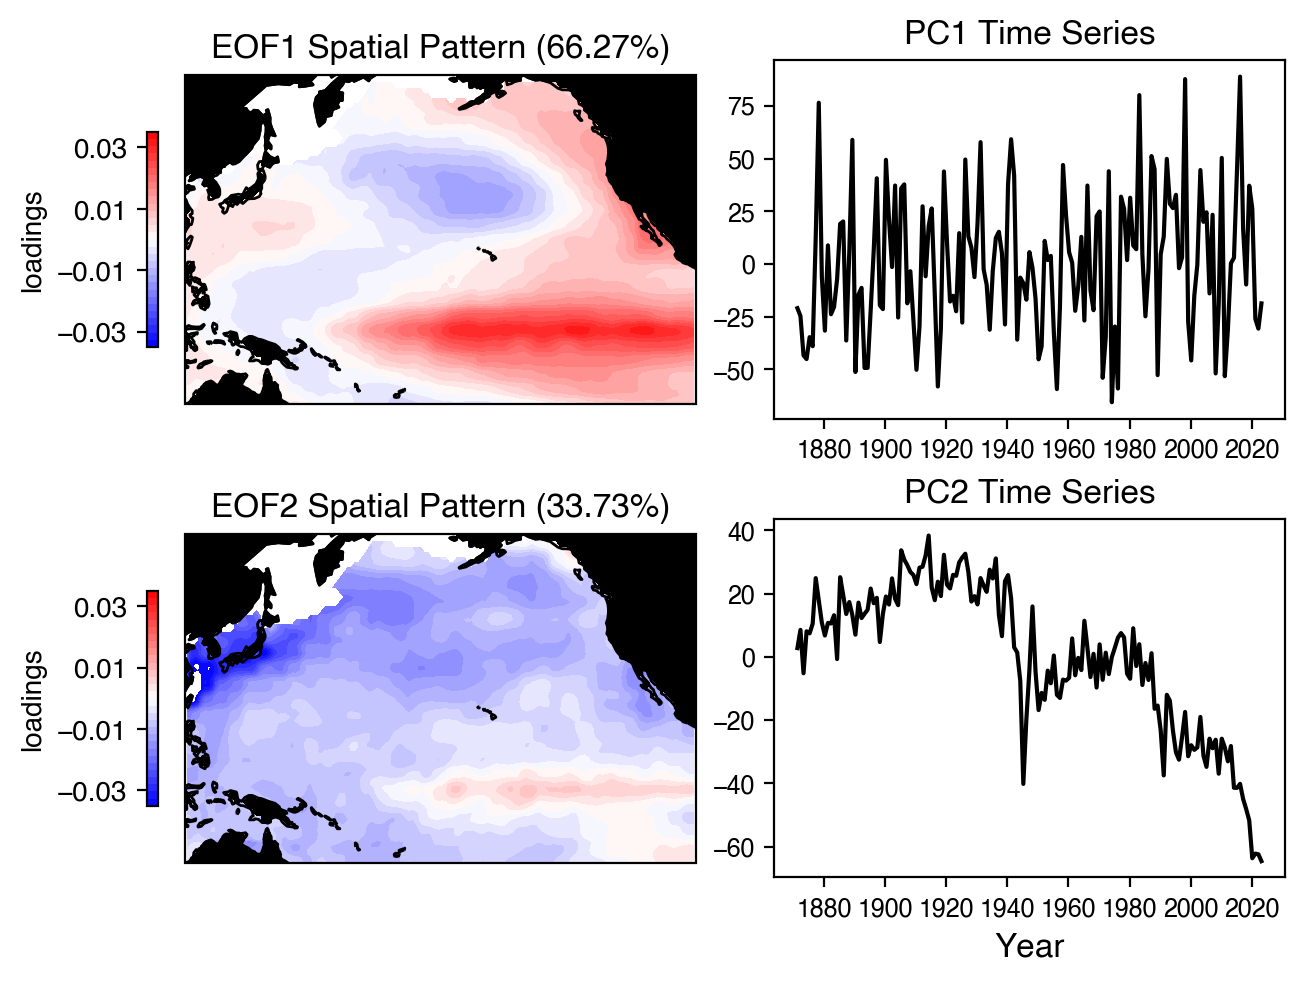

In [107]:
fig=plt.figure(layout="constrained")
gs = fig.add_gridspec(2, 2) # make a 2 row and 2 column spaces
gs.update(wspace=-1, hspace=-0) # we can control some of the spacing on the gridspec

expvar = S/sum(S)
expvar_percentage = expvar * 100

projection=ccrs.Miller(central_longitude=260)# Miller projection centered on the North Pacific

# first subplot, upper left position, map of EOF1 loadings
ax1 = fig.add_subplot(gs[0, 0], projection=projection) # map plot in 1st column of grid
fx1 = ax1.contourf(lon,lat,eof[:,:,0],levels=levels, cmap='bwr',add_colorbar=False, transform=ccrs.PlateCarree())
ax1.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax1.coastlines(color="black") 
ax1.add_feature(cfeature.LAND, color='black')
ax1.set_title(f"EOF1 Spatial Pattern ({expvar_percentage[0]:.2f}%)", fontsize=12)
cb1 = plt.colorbar(fx1, orientation='vertical',location='left',shrink=0.6,ticks=[-0.03, -0.01, 0.01, 0.03])
cb1.set_label('loadings', fontsize=10) 

# second subplot, upper right position, time series plot of PC1 time series corresponding to EOF1
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(winter.time,pcs[:,0],color="black")
ax2.set_title('PC1 Time Series', fontsize=12)
ax2.tick_params(axis="x",labelsize=9)
ax2.tick_params(axis="y",labelsize=9)

# third subplot, lower left position, map of EOF2 loadings
ax3 = fig.add_subplot(gs[1, 0], projection=projection) # map plot in 1st column of grid
fx3 = ax3.contourf(lon,lat,eof[:,:,1],levels=levels, cmap='bwr',add_colorbar=False, transform=ccrs.PlateCarree())
ax3.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax3.coastlines(color="black")  
ax3.add_feature(cfeature.LAND, color='black')
ax3.set_title(f"EOF2 Spatial Pattern ({expvar_percentage[1]:.2f}%)", fontsize=12)
cb3 = plt.colorbar(fx3, orientation='vertical',location='left',shrink=0.6,ticks=[-0.03, -0.01, 0.01, 0.03])
cb3.set_label('loadings', fontsize=10) 

# last subplot, lower right position, time series plot of PC2 time series corresponding to EOF2
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(winter.time,pcs[:,1],color="black")
ax4.set_xlabel('Year',fontsize=12)
ax4.set_title('PC2 Time Series', fontsize=12)
ax4.tick_params(axis="x",labelsize=9)
ax4.tick_params(axis="y",labelsize=9)


How does this figure compare to Figure 1 and Figure 2 in Deser and Blackmon (1995)?  Why might they be different? (and, be sure to read the caption to Deser and Blackmon's Figure 1, to see how they have conveyed they spatial loadings).  You might be interested in a [follow-up paper by Jong-Yeon Park and coauthors that came out in 2012](https://doi.org/10.1029/2011GL050005):

> Park, J.Y., Yeh, S.W. and Kug, J.S., 2012. Revisited relationship between tropical and North Pacific sea surface temperature variations. _Geophysical Research Letters_, 39(2)

And if you're interested in what might be happening in EOF2 here, [start with this now-classic paper](https://www.science.org/doi/full/10.1126/science.275.5302.957):

> Cane, M.A., Clement, A.C., Kaplan, A., Kushnir, Y., Pozdnyakov, D., Seager, R., Zebiak, S.E. and Murtugudde, R., 1997. Twentieth-century sea surface temperature trends. _Science_, 275(5302), 957-960.



